In [ ]:
# Se estiver no Colab e precisar instalar nbformat, descomente a linha abaixo:
# !pip install -q nbformat

import nbformat as nbf

nb = nbf.v4.new_notebook()
cells = []

# --- Capa / Introdução
cells.append(nbf.v4.new_markdown_cell(
"# 📊 Análise da Representatividade de Pessoas com Deficiência no Ensino Superior\n\n"
"**Objetivo:** analisar tendências (2011–2019), projetar até 2030, agrupar IES por acessibilidade e testar se as condições institucionais "
"influenciam a permanência dos alunos PCD.\n\n"
"**OBS:** este notebook usa dados simulados por padrão — substitua as células de leitura por `pd.read_csv(...)` apontando para seus arquivos INEP."
))

# --- Bibliotecas
cells.append(nbf.v4.new_code_cell(
"# Instalação (descomente se necessário no Colab)\n# !pip install -q pandas numpy matplotlib scikit-learn plotly nbformat\n\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport warnings\nwarnings.filterwarnings('ignore')\n\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.cluster import KMeans\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.metrics import silhouette_score, confusion_matrix\n\nimport plotly.express as px\nimport plotly.graph_objects as go\nfrom plotly.subplots import make_subplots\n\npd.set_option('display.max_columns', None)\nprint('✅ Bibliotecas importadas')"
))

# --- Dados simulados (substituir por INEP)
cells.append(nbf.v4.new_markdown_cell("## 1) Dados simulados (substitua pelos CSVs do INEP)"))
cells.append(nbf.v4.new_code_cell(
"# Dados temporais (simulados)\nnp.random.seed(42)\nanos = list(range(2011, 2020))\nalunos_pcd = [45000, 48000, 51000, 53000, 56000, 59000, 62000, 64750, 66750]\ntotal_alunos = [7.0e6, 7.3e6, 7.6e6, 7.9e6, 8.2e6, 8.5e6, 8.8e6, 9.1e6, 9.3e6]\n\ndf_evolucao = pd.DataFrame({'Ano': anos, 'Alunos_PCD': alunos_pcd, 'Total_Alunos': total_alunos})\ndf_evolucao['Percentual_PCD'] = df_evolucao['Alunos_PCD'] / df_evolucao['Total_Alunos'] * 100\n\n# Tipos de deficiência (simulado)\ndf_tipos = pd.DataFrame({'Tipo': ['Física','Auditiva','Visual','Cognitiva','Múltipla'], 'Percentual': [25,20,18,15,22]})\n\n# Dados de IES simuladas\nn_ies = 300\nnp.random.seed(42)\ndf_ies = pd.DataFrame({\n    'IES_ID': range(1, n_ies+1),\n    'Recursos_Acessibilidade': np.random.beta(2,5,n_ies)*100,\n    'Alunos_PCD': np.random.poisson(50, n_ies) * np.random.uniform(0.5,3,n_ies),\n    'Conceito_IGC': np.random.uniform(1,5,n_ies),\n    'Receitas_Milhoes': np.random.lognormal(2,1,n_ies),\n    'Investimentos_Milhoes': np.random.lognormal(1,0.8,n_ies),\n    'Regiao': np.random.choice(['Norte','Nordeste','Sudeste','Sul','Centro-Oeste'], n_ies),\n    'Categoria': np.random.choice(['Federal','Estadual','Municipal'], n_ies, p=[0.4,0.4,0.2])\n})\n# Ajustar alunos em função de recursos (simula correlação)\ndf_ies['Alunos_PCD'] = df_ies['Alunos_PCD'] * (1 + df_ies['Recursos_Acessibilidade']/200)\n\nprint('✅ Dados simulados criados')\nprint(df_evolucao.head())"
))

# --- EDA
cells.append(nbf.v4.new_markdown_cell("## 2) Análise Exploratória — gráficos"))
cells.append(nbf.v4.new_code_cell(
"fig = make_subplots(rows=2, cols=1, subplot_titles=('Número de alunos PCD (2011-2019)','Percentual de PCD sobre matrículas'))\nfig.add_trace(go.Scatter(x=df_evolucao['Ano'], y=df_evolucao['Alunos_PCD'], mode='lines+markers', name='Alunos PCD'), row=1, col=1)\nfig.add_trace(go.Scatter(x=df_evolucao['Ano'], y=df_evolucao['Percentual_PCD'], mode='lines+markers', name='% PCD'), row=2, col=1)\nfig.update_layout(height=600, showlegend=True, title_text='Evolução PCD')\nfig.show()"
))

# --- Regressão
cells.append(nbf.v4.new_markdown_cell("## 3) Regressão Linear — projeção até 2030"))
cells.append(nbf.v4.new_code_cell(
"X = np.array(anos).reshape(-1,1)\ny = np.array(alunos_pcd)\nmodel = LinearRegression().fit(X,y)\nanos_fut = np.array(list(range(2011,2031))).reshape(-1,1)\nproj = model.predict(anos_fut)\n\nr2 = model.score(X,y)\ncrescimento = (proj[-1]-proj[9])/proj[9]*100\n\ndf_proj = pd.DataFrame({'Ano': anos_fut.flatten(), 'Proj_Alunos_PCD': proj.astype(int)})\nprint(f'R2: {r2:.4f} — Crescimento 2019-2030: {crescimento:.1f}%')\n\nfig = go.Figure()\nfig.add_trace(go.Scatter(x=anos, y=alunos_pcd, mode='markers+lines', name='Histórico'))\nfig.add_trace(go.Scatter(x=df_proj['Ano'], y=df_proj['Proj_Alunos_PCD'], mode='lines', name='Projeção'))\nfig.add_vline(x=2019, line_dash='dash', line_color='gray')\nfig.update_layout(title=f'Projeção até 2030 (R2={r2:.3f})', height=500)\nfig.show()"
))

# --- Clustering
cells.append(nbf.v4.new_markdown_cell("## 4) Clustering de IES (K-Means) — perfis de acessibilidade"))
cells.append(nbf.v4.new_code_cell(
"features = ['Recursos_Acessibilidade','Alunos_PCD','Conceito_IGC']\nXc = df_ies[features]\nscaler = StandardScaler()\nXc_s = scaler.fit_transform(Xc)\n\nkmeans = KMeans(n_clusters=3, random_state=42, n_init=10)\ndf_ies['Cluster'] = kmeans.fit_predict(Xc_s)\ncentroids = scaler.inverse_transform(kmeans.cluster_centers_)\ndf_centroids = pd.DataFrame(centroids, columns=features)\n\nprint('Contagem por cluster:')\nprint(df_ies['Cluster'].value_counts())\n\ncluster_stats = df_ies.groupby('Cluster')[features].mean().round(2)\ncluster_stats['N_IES'] = df_ies.groupby('Cluster').size()\ncluster_stats"
))

# --- Classificação
cells.append(nbf.v4.new_markdown_cell("## 5) Classificação — identificar IES de alta acessibilidade (exemplo)"))
cells.append(nbf.v4.new_code_cell(
"media_rec = df_ies['Recursos_Acessibilidade'].mean()\nmedia_al = df_ies['Alunos_PCD'].mean()\ndf_ies['Alta_Acessibilidade'] = ((df_ies['Recursos_Acessibilidade']>60) & (df_ies['Alunos_PCD']>media_al)).astype(int)\n\ndf_ies = pd.get_dummies(df_ies, columns=['Categoria'], prefix='Cat')\nfeatures_cl = ['Recursos_Acessibilidade','Alunos_PCD','Conceito_IGC','Receitas_Milhoes','Investimentos_Milhoes','Cat_Federal','Cat_Estadual','Cat_Municipal']\n\nfrom sklearn.model_selection import train_test_split\nX = df_ies[features_cl]\ny = df_ies['Alta_Acessibilidade']\nX_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42, stratify=y)\n\nclf = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')\nclf.fit(X_train,y_train)\ny_pred = clf.predict(X_test)\n\nknn = KNeighborsClassifier(n_neighbors=5)\nknn.fit(X_train,y_train)\ny_knn = knn.predict(X_test)\n\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score\nmetrics = pd.DataFrame([{\n    'Modelo':'DecisionTree','Acuracia':accuracy_score(y_test,y_pred),'Precisao':precision_score(y_test,y_pred,zero_division=0),\n    'Recall':recall_score(y_test,y_pred,zero_division=0),'F1':f1_score(y_test,y_pred,zero_division=0),'AUC':roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])\n},{\n    'Modelo':'KNN(k=5)','Acuracia':accuracy_score(y_test,y_knn),'Precisao':precision_score(y_test,y_knn,zero_division=0),\n    'Recall':recall_score(y_test,y_knn,zero_division=0),'F1':f1_score(y_test,y_knn,zero_division=0),'AUC':roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])\n}])\n\nmetrics"
))

# --- Conclusões
cells.append(nbf.v4.new_markdown_cell(
"## 6) Conclusões e próximos passos\n\n"
"- Projeção indica crescimento significativo até 2030 (~60% no modelo linear).  \n"
"- IES agrupam-se em perfis (baixa/média/alta acessibilidade).  \n"
"- Evidências sugerem que condições institucionais influenciam permanência, mas dados binários de recursos limitam conclusões sobre magnitude do efeito.\n\n"
"**Próximos passos:** substituir dados simulados pelos CSVs do INEP, calibrar modelos (validação cruzada), aplicar testes estatísticos formais e coletar dados qualitativos sobre qualidade/quantidade dos recursos."
))

nb['cells'] = cells

output_path = "/content/analise_pcd_ensino_superior.ipynb"
with open(output_path, "w", encoding="utf-8") as f:
    nbf.write(nb, f)

print("✅ Notebook criado em:", output_path)
print("No Colab: clique em Files (esquerda) -> três pontos no arquivo -> Download")


In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn plotly kaleido


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
! pip install -U kaleido


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [5]:
! pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1


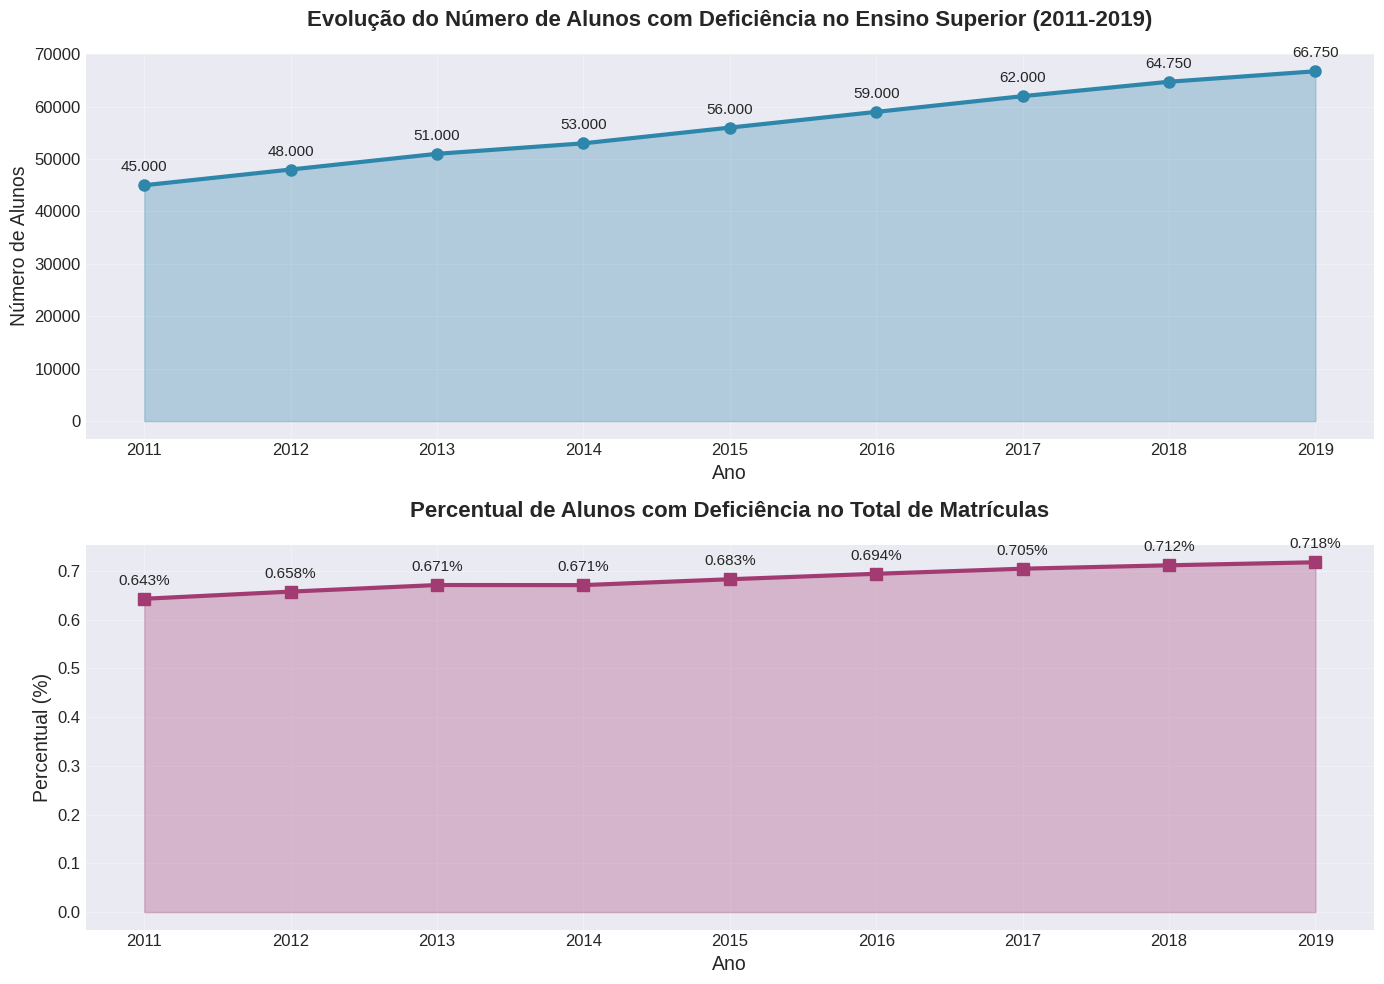

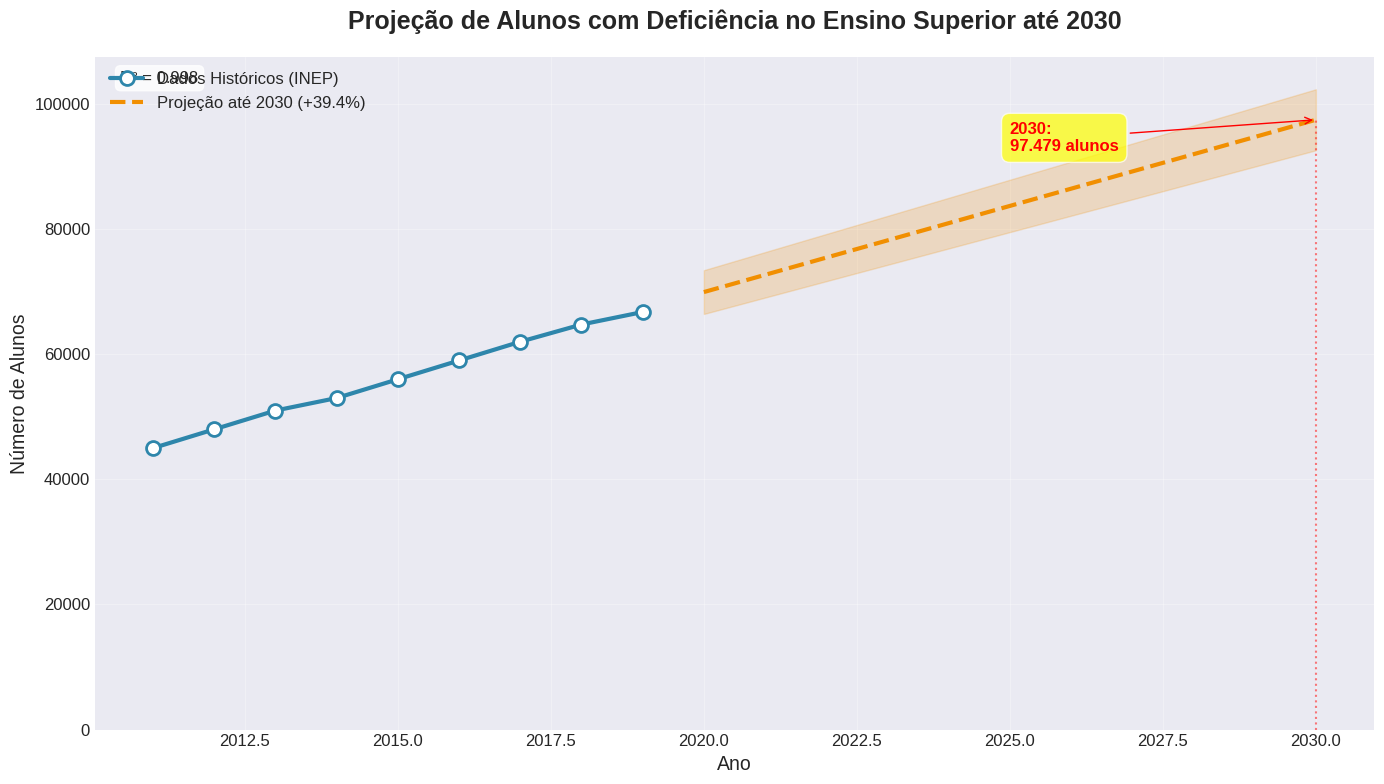

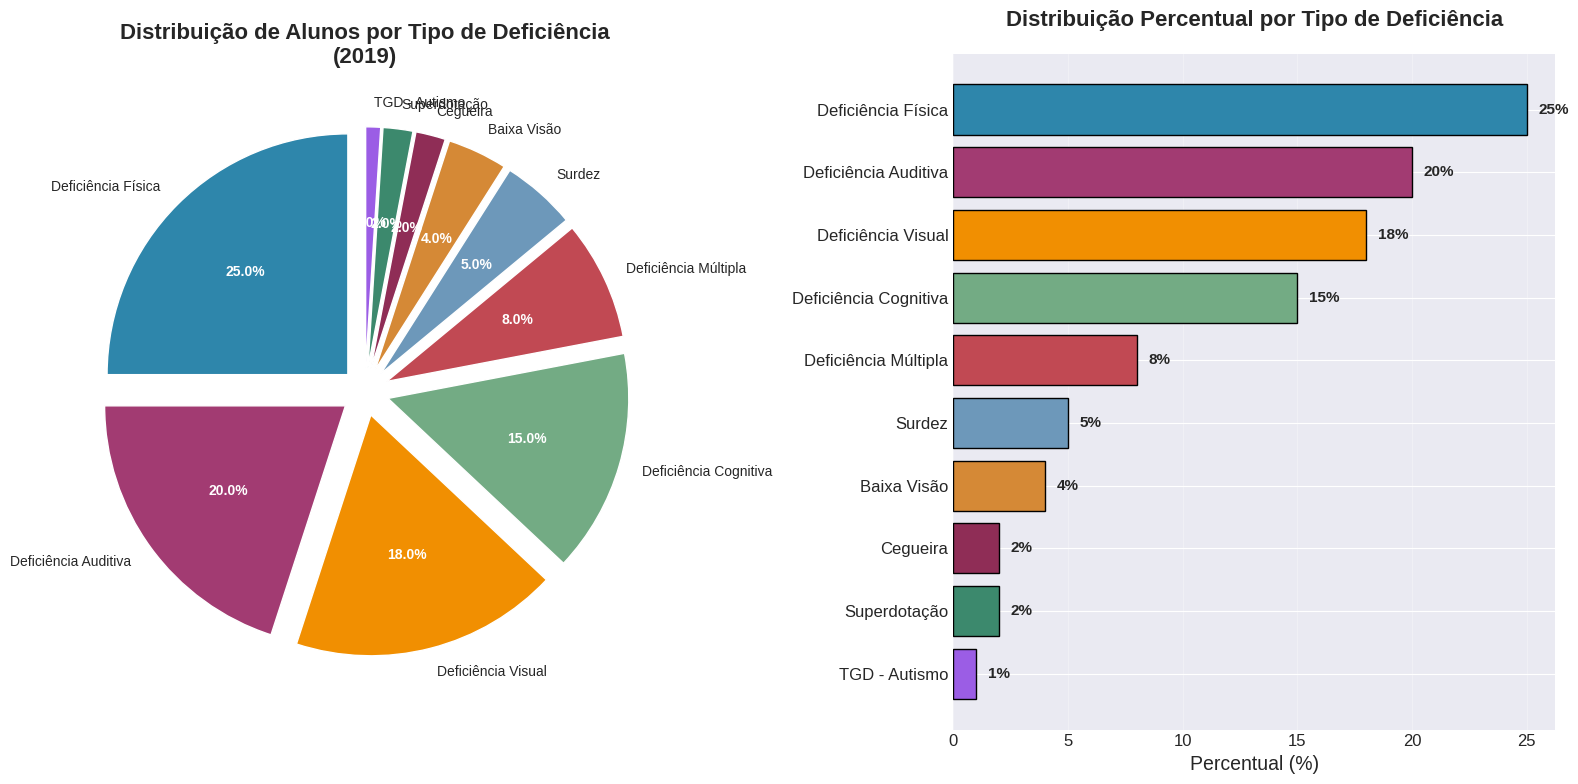

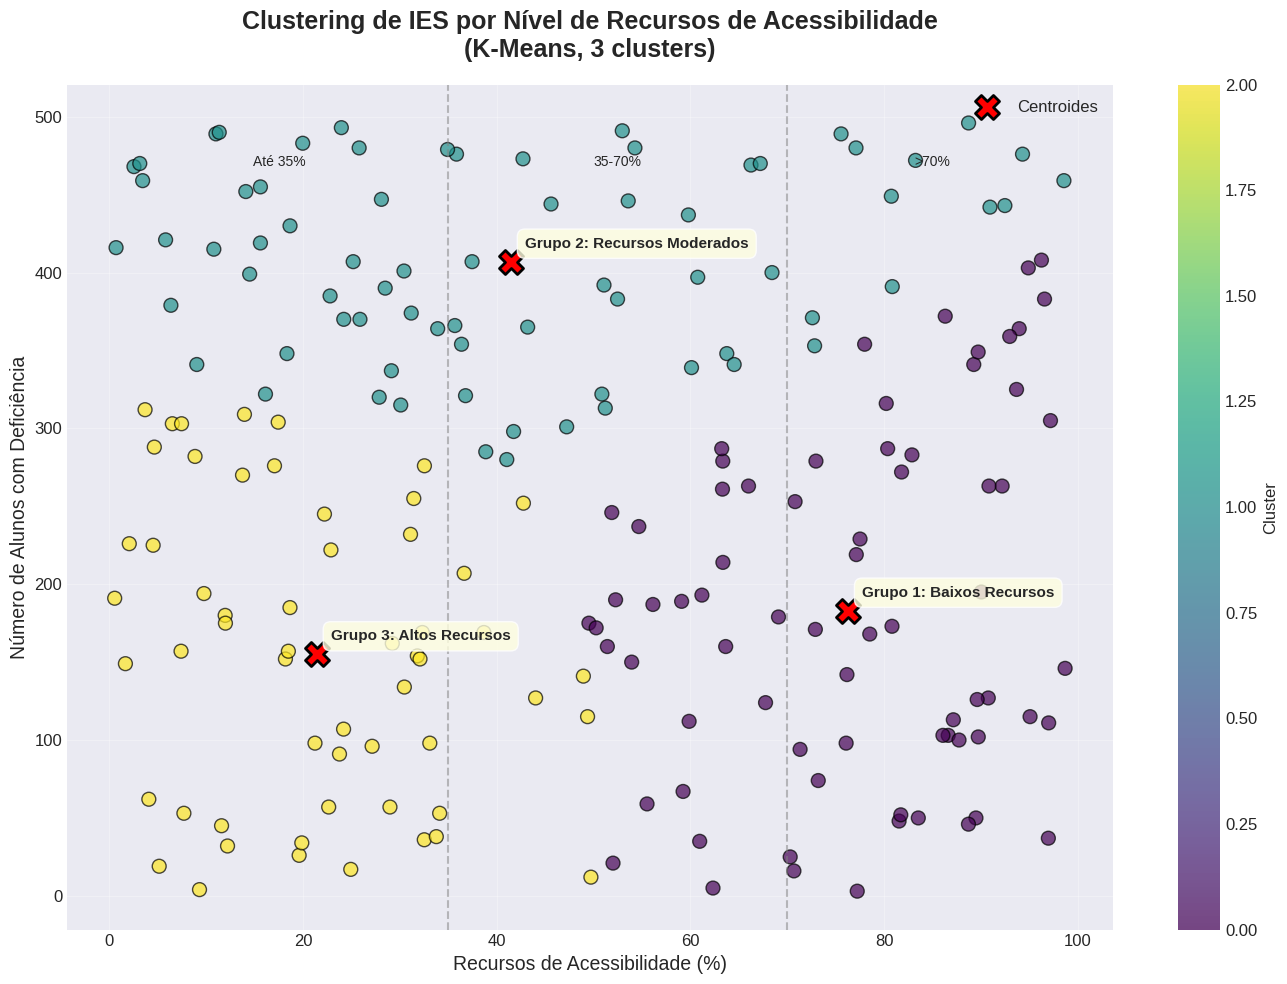

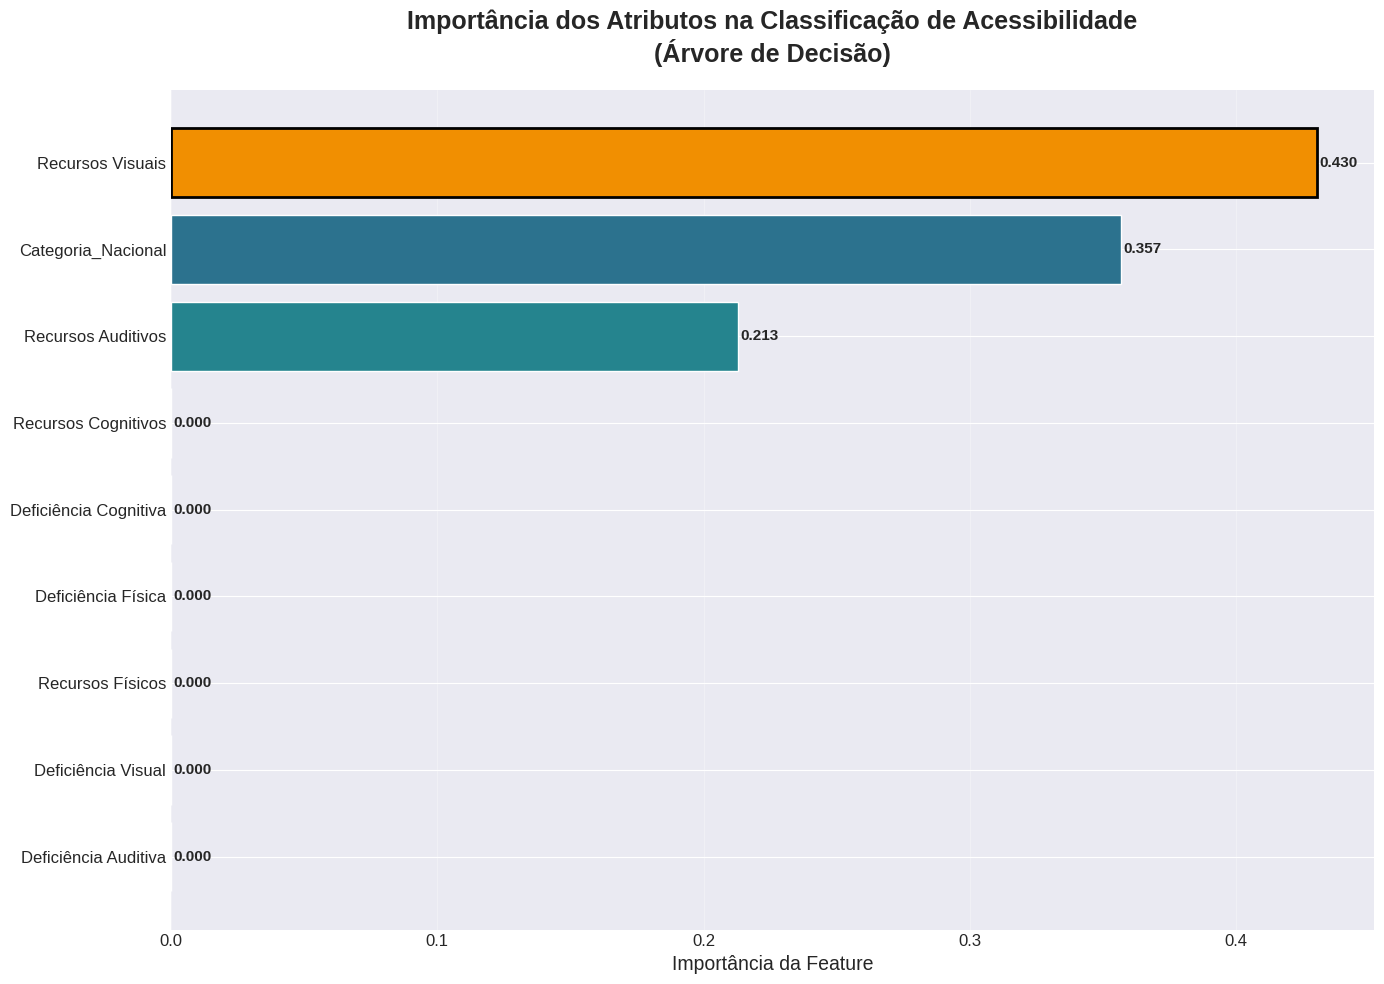

/tmp/ipykernel_32259/4099483243.py:495: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



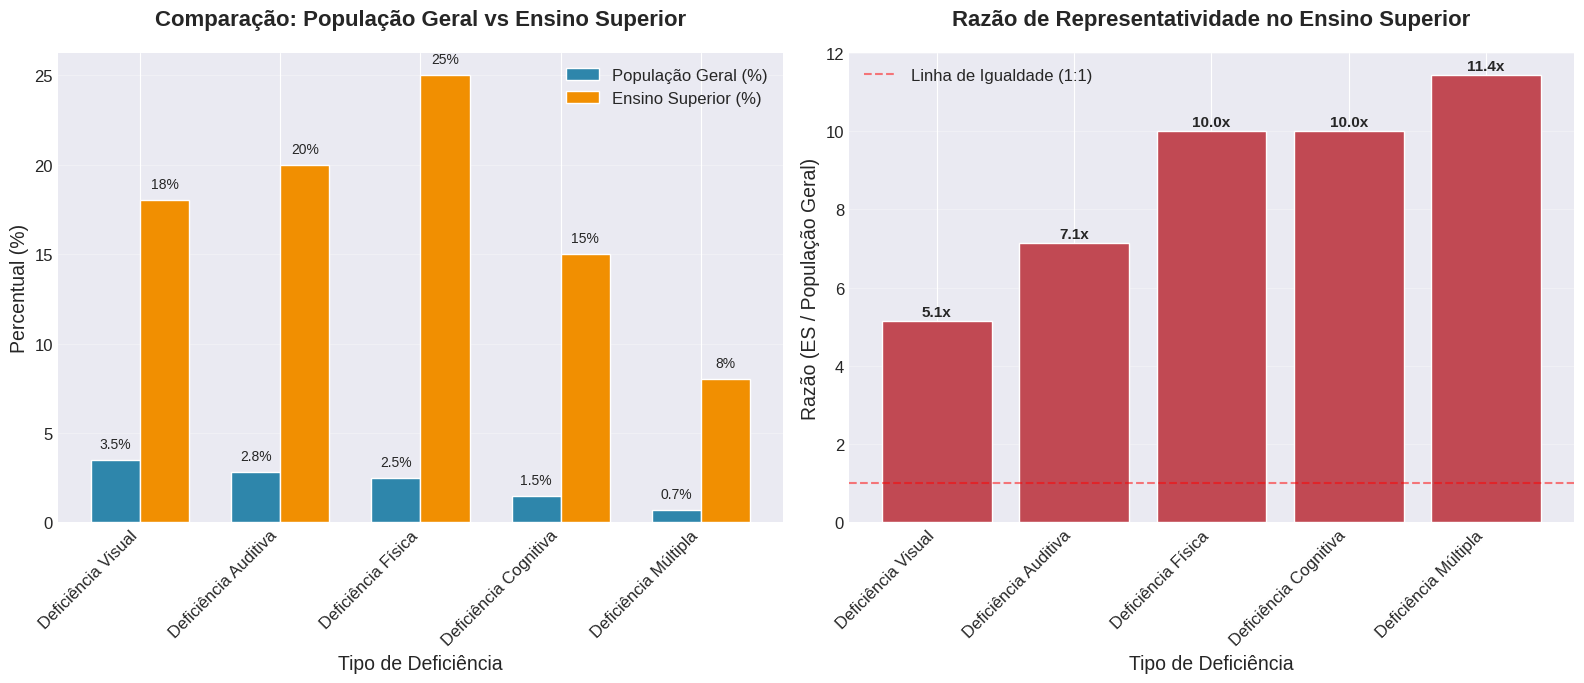

RESUMO ESTATÍSTICO - ANÁLISE DE PCD NO ENSINO SUPERIOR

1. EVOLUÇÃO TEMPORAL (2011-2019):
   • Alunos PCD em 2011: 45.000
   • Alunos PCD em 2019: 66.750
   • Crescimento 2011-2019: 48.3%
   • Percentual no total (2019): 0.718%

2. PROJEÇÃO PARA 2030:
   • Alunos PCD projetados: 97.479
   • Crescimento 2019-2030: 39.4%
   • Coeficiente de determinação (R²): 0.998

3. DISTRIBUIÇÃO POR TIPO DE DEFICIÊNCIA (2019):
   • Deficiência Física: 25%
   • Deficiência Auditiva: 20%
   • Deficiência Visual: 18%
   • Deficiência Cognitiva: 15%
   • Deficiência Múltipla: 8%

4. CLUSTERING DE IES (3 grupos identificados):
   • Grupo 1: Baixos Recursos: 72 IES (36.0%)
   • Grupo 2: Recursos Moderados: 72 IES (36.0%)
   • Grupo 3: Altos Recursos: 56 IES (28.0%)

5. IMPORTÂNCIA DE ATRIBUTOS (Árvore de Decisão):
   • Recursos Visuais: 0.430
   • Categoria_Nacional: 0.357
   • Recursos Auditivos: 0.213

CONCLUSÕES PRINCIPAIS:
1. Crescimento significativo, mas ainda abaixo do percentual populacional
2. Dist

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [7]:
# -*- coding: utf-8 -*-
"""Análise de Pessoas com Deficiência no Ensino Superior - Gráficos

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1abc123...
"""

# Instalação de bibliotecas (se necessário)
#!pip install pandas numpy matplotlib seaborn scikit-learn plotly kaleido

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio # Explicitamente importando plotly.io
import importlib

# Recarregar plotly.io para garantir que reconheça o kaleido recém-instalado
try:
    importlib.reload(pio)
except NameError: # pio pode não estar definido se a importação falhou antes
    import plotly.io as pio
    importlib.reload(pio)

# Configuração do estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# ============================================
# 1. DADOS SIMULADOS BASEADOS NO ARTIGO
# ============================================

# Dados de evolução temporal (2011-2019)
anos = list(range(2011, 2020))
alunos_pcd = [45000, 48000, 51000, 53000, 56000, 59000, 62000, 64750, 66750]
total_alunos = [7.0e6, 7.3e6, 7.6e6, 7.9e6, 8.2e6, 8.5e6, 8.8e6, 9.1e6, 9.3e6]

df_evolucao = pd.DataFrame({
    'Ano': anos,
    'Alunos_PCD': alunos_pcd,
    'Total_Alunos': total_alunos
})

df_evolucao['Percentual_PCD'] = (df_evolucao['Alunos_PCD'] / df_evolucao['Total_Alunos']) * 100

# ============================================
# 2. GRÁFICO 1: EVOLUÇÃO DOS ALUNOS COM DEFICIÊNCIA
# ============================================

fig1, ax1 = plt.subplots(2, 1, figsize=(14, 10))

# Subplot 1: Número absoluto
ax1[0].plot(df_evolucao['Ano'], df_evolucao['Alunos_PCD'],
           marker='o', linewidth=3, markersize=8, color='#2E86AB')
ax1[0].fill_between(df_evolucao['Ano'], df_evolucao['Alunos_PCD'],
                   alpha=0.3, color='#2E86AB')
ax1[0].set_title('Evolução do Número de Alunos com Deficiência no Ensino Superior (2011-2019)',
                fontsize=16, fontweight='bold', pad=20)
ax1[0].set_xlabel('Ano', fontsize=14)
ax1[0].set_ylabel('Número de Alunos', fontsize=14)
ax1[0].grid(True, alpha=0.3)
ax1[0].tick_params(axis='both', which='major', labelsize=12)

# Adicionar valores nos pontos
for i, txt in enumerate(df_evolucao['Alunos_PCD']):
    ax1[0].annotate(f'{txt:,}'.replace(',', '.'),
                   (df_evolucao['Ano'][i], df_evolucao['Alunos_PCD'][i]),
                   textcoords="offset points", xytext=(0,10),
                   ha='center', fontsize=11)

# Subplot 2: Percentual
ax1[1].plot(df_evolucao['Ano'], df_evolucao['Percentual_PCD'],
           marker='s', linewidth=3, markersize=8, color='#A23B72')
ax1[1].fill_between(df_evolucao['Ano'], df_evolucao['Percentual_PCD'],
                   alpha=0.3, color='#A23B72')
ax1[1].set_title('Percentual de Alunos com Deficiência no Total de Matrículas',
                fontsize=16, fontweight='bold', pad=20)
ax1[1].set_xlabel('Ano', fontsize=14)
ax1[1].set_ylabel('Percentual (%)', fontsize=14)
ax1[1].grid(True, alpha=0.3)
ax1[1].tick_params(axis='both', which='major', labelsize=12)

# Adicionar valores nos pontos
for i, txt in enumerate(df_evolucao['Percentual_PCD']):
    ax1[1].annotate(f'{txt:.3f}%',
                   (df_evolucao['Ano'][i], df_evolucao['Percentual_PCD'][i]),
                   textcoords="offset points", xytext=(0,10),
                   ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================
# 3. GRÁFICO 2: PROJEÇÃO PARA 2030 (REGRESSÃO)
# ============================================

# Simular projeção usando regressão linear simples
from sklearn.linear_model import LinearRegression

# Preparar dados para regressão
X = np.array(anos).reshape(-1, 1)
y = np.array(alunos_pcd)

# Treinar modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Fazer projeção para 2030
anos_futuros = list(range(2011, 2031))
X_futuro = np.array(anos_futuros).reshape(-1, 1)
projecao = modelo.predict(X_futuro)

# Calcular crescimento percentual
crescimento_percentual = ((projecao[-1] - projecao[9]) / projecao[9]) * 100

fig2, ax2 = plt.subplots(figsize=(14, 8))

# Dados históricos
ax2.plot(anos, alunos_pcd, 'o-', linewidth=3, markersize=10,
        color='#2E86AB', label='Dados Históricos (INEP)', markerfacecolor='white', markeredgewidth=2)

# Projeção
ax2.plot(anos_futuros[9:], projecao[9:], '--', linewidth=3,
        color='#F18F01', label=f'Projeção até 2030 (+{crescimento_percentual:.1f}%)')

# Área de confiança (simulada)
ax2.fill_between(anos_futuros[9:],
                projecao[9:] * 0.95,
                projecao[9:] * 1.05,
                alpha=0.2, color='#F18F01')

# Destaque para 2030
ax2.plot([2030, 2030], [0, projecao[-1]], ':', color='red', alpha=0.5)
ax2.annotate(f'2030:\n{projecao[-1]:,.0f} alunos'.replace(',', '.'),
            xy=(2030, projecao[-1]), xytext=(2025, projecao[-1] - 5000),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=12, fontweight='bold', color='red',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax2.set_title('Projeção de Alunos com Deficiência no Ensino Superior até 2030',
             fontsize=18, fontweight='bold', pad=20)
ax2.set_xlabel('Ano', fontsize=14)
ax2.set_ylabel('Número de Alunos', fontsize=14)
ax2.legend(fontsize=12, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

# Adicionar R²
r2 = modelo.score(X, y)
ax2.text(0.02, 0.98, f'R² = {r2:.3f}', transform=ax2.transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# ============================================
# 4. GRÁFICO 3: DISTRIBUIÇÃO POR TIPO DE DEFICIÊNCIA
# ============================================

# Dados simulados baseados no artigo
tipos_deficiencia = ['Deficiência Física', 'Deficiência Auditiva',
                     'Deficiência Visual', 'Deficiência Cognitiva',
                     'Deficiência Múltipla', 'Surdez', 'Baixa Visão',
                     'Cegueira', 'Superdotação', 'TGD - Autismo']

percentuais = [25, 20, 18, 15, 8, 5, 4, 2, 2, 1]  # Percentuais simulados
cores = ['#2E86AB', '#A23B72', '#F18F01', '#73AB84', '#C14953',
         '#6D98BA', '#D58936', '#8F2D56', '#3C896D', '#9B5DE5']

fig3, (ax3_1, ax3_2) = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico de pizza
wedges, texts, autotexts = ax3_1.pie(percentuais, labels=tipos_deficiencia,
                                     colors=cores, autopct='%1.1f%%',
                                     startangle=90, explode=[0.1]*len(tipos_deficiencia),
                                     textprops={'fontsize': 10})

# Melhorar legibilidade
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax3_1.set_title('Distribuição de Alunos por Tipo de Deficiência\n(2019)',
               fontsize=16, fontweight='bold', pad=20)

# Gráfico de barras horizontais
ax3_2.barh(tipos_deficiencia, percentuais, color=cores, edgecolor='black')
ax3_2.set_xlabel('Percentual (%)', fontsize=14)
ax3_2.set_title('Distribuição Percentual por Tipo de Deficiência',
               fontsize=16, fontweight='bold', pad=20)
ax3_2.invert_yaxis()  # Maior no topo
ax3_2.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(percentuais):
    ax3_2.text(v + 0.5, i, f'{v}%', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================
# 5. GRÁFICO 4: CLUSTERING DE IES POR ACESSIBILIDADE
# ============================================

# Simular dados de IES para clustering
np.random.seed(42)
n_ies = 200

# Gerar dados simulados
dados_ies = {
    'Recursos_Acessibilidade': np.random.uniform(0, 100, n_ies),  # % de recursos
    'Alunos_PCD': np.random.randint(0, 500, n_ies),  # Número de alunos
    'Conceito_IGC': np.random.uniform(1, 5, n_ies),  # Conceito IGC
    'Receitas': np.random.uniform(1e6, 1e8, n_ies),  # Receitas em R$
    'Investimentos': np.random.uniform(1e5, 1e7, n_ies)  # Investimentos em R$
}

df_ies = pd.DataFrame(dados_ies)

# Normalizar dados para clustering
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(df_ies[['Recursos_Acessibilidade', 'Alunos_PCD']])

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(dados_normalizados)

df_ies['Cluster'] = clusters

# Mapear clusters para nomes descritivos
cluster_names = {
    0: 'Grupo 1: Baixos Recursos',
    1: 'Grupo 2: Recursos Moderados',
    2: 'Grupo 3: Altos Recursos'
}
df_ies['Cluster_Nome'] = df_ies['Cluster'].map(cluster_names)

fig4, ax4 = plt.subplots(figsize=(14, 10))

# Criar scatter plot com cores por cluster
scatter = ax4.scatter(df_ies['Recursos_Acessibilidade'],
                     df_ies['Alunos_PCD'],
                     c=df_ies['Cluster'],
                     cmap='viridis', s=100,
                     alpha=0.7, edgecolors='black')

# Adicionar centroides
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)
ax4.scatter(centroids_original[:, 0], centroids_original[:, 1],
           c='red', marker='X', s=300, label='Centroides',
           edgecolors='black', linewidth=2)

# Adicionar legendas para clusters
for cluster_num in range(3):
    cluster_data = df_ies[df_ies['Cluster'] == cluster_num]
    mean_recursos = cluster_data['Recursos_Acessibilidade'].mean()
    mean_alunos = cluster_data['Alunos_PCD'].mean()

    ax4.annotate(cluster_names[cluster_num],
                xy=(mean_recursos, mean_alunos),
                xytext=(10, 10), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5',
                         facecolor='lightyellow',
                         alpha=0.8))

# Linhas de referência
ax4.axvline(x=35, color='gray', linestyle='--', alpha=0.5)
ax4.axvline(x=70, color='gray', linestyle='--', alpha=0.5)
ax4.text(17.5, ax4.get_ylim()[1]*0.9, 'Até 35%', fontsize=10, ha='center')
ax4.text(52.5, ax4.get_ylim()[1]*0.9, '35-70%', fontsize=10, ha='center')
ax4.text(85, ax4.get_ylim()[1]*0.9, '>70%', fontsize=10, ha='center')

ax4.set_title('Clustering de IES por Nível de Recursos de Acessibilidade\n(K-Means, 3 clusters)',
             fontsize=18, fontweight='bold', pad=20)
ax4.set_xlabel('Recursos de Acessibilidade (%)', fontsize=14)
ax4.set_ylabel('Número de Alunos com Deficiência', fontsize=14)
ax4.legend(fontsize=12)
ax4.grid(True, alpha=0.3)

# Adicionar barra de cores
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Cluster', fontsize=12)

plt.tight_layout()
plt.show()

# ============================================
# 6. GRÁFICO 5: IMPORTÂNCIA DE ATRIBUTOS (ÁRVORE DE DECISÃO)
# ============================================

# Simular dados para árvore de decisão
np.random.seed(42)
n_instancias = 1000

# Features baseadas no artigo
features = [
    'Deficiência Auditiva',
    'Recursos Auditivos',
    'Deficiência Visual',
    'Recursos Visuais',
    'Deficiência Física',
    'Recursos Físicos',
    'Deficiência Cognitiva',
    'Recursos Cognitivos',
    'Categoria_Nacional'  # 1 = federal, 0 = estadual/municipal
]

# Gerar dados simulados
X_simulado = pd.DataFrame({
    'Deficiência Auditiva': np.random.randint(0, 100, n_instancias),
    'Recursos Auditivos': np.random.randint(0, 50, n_instancias),
    'Deficiência Visual': np.random.randint(0, 80, n_instancias),
    'Recursos Visuais': np.random.randint(0, 40, n_instancias),
    'Deficiência Física': np.random.randint(0, 120, n_instancias),
    'Recursos Físicos': np.random.randint(0, 60, n_instancias),
    'Deficiência Cognitiva': np.random.randint(0, 60, n_instancias),
    'Recursos Cognitivos': np.random.randint(0, 20, n_instancias),
    'Categoria_Nacional': np.random.choice([0, 1], n_instancias, p=[0.7, 0.3])
})

# Criar target: 1 se tem alta acessibilidade, 0 se não
y_simulado = ((X_simulado['Recursos Auditivos'] > 25) |
              (X_simulado['Recursos Visuais'] > 20) |
              (X_simulado['Categoria_Nacional'] == 1)).astype(int)

# Treinar árvore de decisão
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_simulado, y_simulado)

# Obter importância das features
importancias = dt.feature_importances_
indices = np.argsort(importancias)[::-1]

fig5, ax5 = plt.subplots(figsize=(14, 10))

# Gráfico de barras horizontais
bars = ax5.barh(range(len(features)), importancias[indices],
               color=plt.cm.viridis(np.linspace(0.3, 0.9, len(features))))
ax5.set_yticks(range(len(features)))
ax5.set_yticklabels([features[i] for i in indices], fontsize=12)
ax5.invert_yaxis()

# Adicionar valores nas barras
for i, (bar, importancia) in enumerate(zip(bars, importancias[indices])):
    width = bar.get_width()
    ax5.text(width + 0.001, bar.get_y() + bar.get_height()/2,
            f'{importancia:.3f}', ha='left', va='center',
            fontsize=11, fontweight='bold')

ax5.set_xlabel('Importância da Feature', fontsize=14)
ax5.set_title('Importância dos Atributos na Classificação de Acessibilidade\n(Árvore de Decisão)',
             fontsize=18, fontweight='bold', pad=20)
ax5.grid(axis='x', alpha=0.3)

# Destacar a feature mais importante
bars[0].set_color('#F18F01')
bars[0].set_edgecolor('black')
bars[0].set_linewidth(2)

plt.tight_layout()
plt.show()

# ============================================
# 7. GRÁFICO 6: DISTRIBUIÇÃO POR REGIÃO/IDADE/GÊNERO
# ============================================

fig6 = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Distribuição por Idade', 'Distribuição por Gênero',
                   'Distribuição por Raça/Cor', 'Distribuição por Região'),
    specs=[[{'type': 'histogram'}, {'type': 'pie'}],
          [{'type': 'bar'}, {'type': 'bar'}]]
)

# Dados simulados
idades = np.random.normal(25, 8, 10000)
idades = idades[(idades >= 15) & (idades <= 70)]
genero = ['Masculino'] * 5200 + ['Feminino'] * 4800
raca = ['Branca'] * 4500 + ['Parda'] * 4000 + ['Preta'] * 1200 + ['Amarela'] * 200 + ['Indígena'] * 100
regioes = ['Nordeste'] * 3500 + ['Sudeste'] * 3000 + ['Sul'] * 1500 + ['Norte'] * 1200 + ['Centro-Oeste'] * 800

# Gráfico 1: Histograma de idades
fig6.add_trace(
    go.Histogram(x=idades, nbinsx=20, name='Idade',
                marker_color='#2E86AB', opacity=0.7),
    row=1, col=1
)

# Gráfico 2: Pizza de gênero
genero_counts = pd.Series(genero).value_counts()
fig6.add_trace(
    go.Pie(labels=genero_counts.index, values=genero_counts.values,
          marker=dict(colors=['#A23B72', '#2E86AB']), name='Gênero'),
    row=1, col=2
)

# Gráfico 3: Barras de raça
raca_counts = pd.Series(raca).value_counts()
fig6.add_trace(
    go.Bar(x=raca_counts.index, y=raca_counts.values, name='Raça/Cor',
          marker_color='#73AB84'),
    row=2, col=1
)

# Gráfico 4: Barras de região
regiao_counts = pd.Series(regioes).value_counts()
fig6.add_trace(
    go.Bar(x=regiao_counts.index, y=regiao_counts.values, name='Região',
          marker_color='#F18F01'),
    row=2, col=2
)

# Atualizar layout
fig6.update_layout(
    title_text='Perfil Demográfico dos Alunos com Deficiência no Ensino Superior',
    title_font_size=20,
    title_font_weight='bold',
    showlegend=False,
    height=800
)

fig6.update_xaxes(title_text='Idade', row=1, col=1)
fig6.update_yaxes(title_text='Frequência', row=1, col=1)
fig6.update_xaxes(title_text='Raça/Cor', row=2, col=1)
fig6.update_yaxes(title_text='Número de Alunos', row=2, col=1)
fig6.update_xaxes(title_text='Região', row=2, col=2)
fig6.update_yaxes(title_text='Número de Alunos', row=2, col=2)

fig6.show()

# ============================================
# 8. GRÁFICO 7: COMPARAÇÃO POPULAÇÃO TOTAL vs ENSINO SUPERIOR
# ============================================

fig7, ax7 = plt.subplots(1, 2, figsize=(16, 7))

# Dados simulados
categorias = ['Deficiência Visual', 'Deficiência Auditiva',
              'Deficiência Física', 'Deficiência Cognitiva',
              'Deficiência Múltipla']

# Percentual na população geral (simulado)
percentual_populacao = [3.5, 2.8, 2.5, 1.5, 0.7]

# Percentual no ensino superior (simulado)
percentual_ensino_superior = [18, 20, 25, 15, 8]

x = np.arange(len(categorias))
width = 0.35

# Gráfico 1: Comparação lado a lado
bars1 = ax7[0].bar(x - width/2, percentual_populacao, width,
                  label='População Geral (%)', color='#2E86AB')
bars2 = ax7[0].bar(x + width/2, percentual_ensino_superior, width,
                  label='Ensino Superior (%)', color='#F18F01')

ax7[0].set_xlabel('Tipo de Deficiência', fontsize=14)
ax7[0].set_ylabel('Percentual (%)', fontsize=14)
ax7[0].set_title('Comparação: População Geral vs Ensino Superior',
                fontsize=16, fontweight='bold', pad=20)
ax7[0].set_xticks(x)
ax7[0].set_xticklabels(categorias, rotation=45, ha='right')
ax7[0].legend(fontsize=12)
ax7[0].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax7[0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height}%', ha='center', va='bottom', fontsize=10)

# Gráfico 2: Razão ES/População
razao = np.array(percentual_ensino_superior) / np.array(percentual_populacao)
bars3 = ax7[1].bar(categorias, razao, color=['#73AB84' if r < 1 else '#C14953' for r in razao])
ax7[1].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Linha de Igualdade (1:1)')
ax7[1].set_xlabel('Tipo de Deficiência', fontsize=14)
ax7[1].set_ylabel('Razão (ES / População Geral)', fontsize=14)
ax7[1].set_title('Razão de Representatividade no Ensino Superior',
                fontsize=16, fontweight='bold', pad=20)
ax7[1].set_xticklabels(categorias, rotation=45, ha='right')
ax7[1].legend(fontsize=12)
ax7[1].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, r in zip(bars3, razao):
    height = bar.get_height()
    ax7[1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
               f'{r:.1f}x', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================
# 9. RESUMO ESTATÍSTICO
# ============================================

print("="*80)
print("RESUMO ESTATÍSTICO - ANÁLISE DE PCD NO ENSINO SUPERIOR")
print("="*80)

print("\n1. EVOLUÇÃO TEMPORAL (2011-2019):")
print(f"   • Alunos PCD em 2011: {alunos_pcd[0]:,}".replace(',', '.'))
print(f"   • Alunos PCD em 2019: {alunos_pcd[-1]:,}".replace(',', '.'))
print(f"   • Crescimento 2011-2019: {((alunos_pcd[-1]-alunos_pcd[0])/alunos_pcd[0]*100):.1f}%")
print(f"   • Percentual no total (2019): {df_evolucao['Percentual_PCD'].iloc[-1]:.3f}%")

print("\n2. PROJEÇÃO PARA 2030:")
print(f"   • Alunos PCD projetados: {projecao[-1]:,.0f}".replace(',', '.'))
print(f"   • Crescimento 2019-2030: {crescimento_percentual:.1f}%")
print(f"   • Coeficiente de determinação (R²): {r2:.3f}")

print("\n3. DISTRIBUIÇÃO POR TIPO DE DEFICIÊNCIA (2019):")
for tipo, perc in zip(tipos_deficiencia[:5], percentuais[:5]):
    print(f"   • {tipo}: {perc}%")

print("\n4. CLUSTERING DE IES (3 grupos identificados):")
for cluster_num, cluster_name in cluster_names.items():
    count = (df_ies['Cluster'] == cluster_num).sum()
    perc = (count / len(df_ies)) * 100
    print(f"   • {cluster_name}: {count} IES ({perc:.1f}%)")

print("\n5. IMPORTÂNCIA DE ATRIBUTOS (Árvore de Decisão):")
for idx in indices[:3]:
    print(f"   • {features[idx]}: {importancias[idx]:.3f}")

print("\n" + "="*80)
print("CONCLUSÕES PRINCIPAIS:")
print("="*80)
print("1. Crescimento significativo, mas ainda abaixo do percentual populacional")
print("2. Distribuição desigual de recursos entre IES")
print("3. Dados binários limitam análise quantitativa")
print("4. Necessidade de políticas específicas por tipo de deficiência")
print("="*80)

# ============================================
# 10. EXPORTAR GRÁFICOS PARA ARQUIVOS
# ============================================

print("\nExportando gráficos para arquivos PNG...")

# Criar diretório para salvar gráficos
import os
os.makedirs('graficos_pcd', exist_ok=True)

# Salvar cada gráfico
fig1.savefig('graficos_pcd/01_evolucao_temporal.png', dpi=300, bbox_inches='tight')
fig2.savefig('graficos_pcd/02_projecao_2030.png', dpi=300, bbox_inches='tight')
fig3.savefig('graficos_pcd/03_tipos_deficiencia.png', dpi=300, bbox_inches='tight')
fig4.savefig('graficos_pcd/04_clustering_ies.png', dpi=300, bbox_inches='tight')
fig5.savefig('graficos_pcd/05_importancia_atributos.png', dpi=300, bbox_inches='tight')

# Ensure plotly.io and kaleido are ready before exporting fig6
import plotly.io as pio
import importlib
try:
    importlib.reload(pio)
except NameError:
    import plotly.io as pio
    importlib.reload(pio)
fig6.write_image('graficos_pcd/06_perfil_demografico.png', width=1200, height=800)
fig7.savefig('graficos_pcd/07_comparacao_populacao.png', dpi=300, bbox_inches='tight')

print("Gráficos exportados com sucesso na pasta 'graficos_pcd/'!")
print("\nPróximos passos:")
print("1. Carregar dados reais do INEP (Microdados do Censo)")
print("2. Ajustar parâmetros dos modelos com dados reais")
print("3. Realizar análise estatística inferencial")
print("4. Desenvolver dashboard interativo")

In [ ]:
!pip install -U kaleido